<a href="https://colab.research.google.com/github/AmiranGozalishvili/Data_Science_course/blob/main/Large_Movie_Review_Dataset_NN_NLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install pandas_profiling --upgrade
!pip install contractions
!pip install autocorrect
!pip install opendatasets

In [ ]:
import os.path
import pandas as pd
import numpy as np
import pandas_profiling
import matplotlib.pyplot as plt
import seaborn as sns
import csv
import re
import contractions
import opendatasets
import spacy
import json
import string


from tqdm.notebook import tqdm_notebook
# # initiate tqdm for pandas.apply() functions
tqdm_notebook.pandas()

import warnings
warnings.filterwarnings('ignore')

# plt.rcParams['figure.figsize'] = 7, 7
plt.style.use('ggplot')

<ipython-input-2-da066201b646>:4: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  import pandas_profiling


In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('omw-1.4')
from nltk import download
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, RocCurveDisplay, roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, auc
from sklearn.metrics import SCORERS, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, KFold
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from wordcloud import WordCloud

from sklearn.metrics import make_scorer, fbeta_score

import torch
import torch.nn as nn
import torch.nn.functional as F
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset, DataLoader
import numpy as num

import time
import math
from IPython.display import clear_output
%matplotlib inline

import torch.autograd as autograd
import torch.nn.functional as F
import torch.optim as optim

np.random.seed(42)

from collections import Counter
from sklearn.metrics.pairwise import cosine_similarity
import random

from sklearn.metrics.pairwise import cosine_similarity
import gensim.downloader as api
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import bokeh.models as bm, bokeh.plotting as pl
from bokeh.io import output_notebook

from gensim.models import Word2Vec

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Import dataframe

In [ ]:
data = pd.read_csv('/content/LargeMovieReviewDataset.csv', engine='python', encoding='utf-8')

# EDA

In [ ]:
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
data.columns

Index(['review', 'sentiment'], dtype='object')

In [ ]:
data.review

0        One of the other reviewers has mentioned that ...
1        A wonderful little production. <br /><br />The...
2        I thought this was a wonderful way to spend ti...
3        Basically there's a family where a little boy ...
4        Petter Mattei's "Love in the Time of Money" is...
                               ...                        
49995    I thought this movie did a down right good job...
49996    Bad plot, bad dialogue, bad acting, idiotic di...
49997    I am a Catholic taught in parochial elementary...
49998    I'm going to have to disagree with the previou...
49999    No one expects the Star Trek movies to be high...
Name: review, Length: 50000, dtype: object

In [ ]:
data.describe()

,review,sentiment
count,50000,50000
unique,49582,2
top,Loved today's show!!! It was a variety and not...,positive
freq,5,25000


In [ ]:
data.sentiment.value_counts()

positive    25000
negative    25000
Name: sentiment, dtype: int64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
pandas_profiling.ProfileReport(data)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

EDA conclusion: from review of dataframe we see that there are two column,

'review' and 'sentiment'. column 'sentiment' is our target.

also we can see that there are no missing rows, but we have some duplicated

rows, which can be droped from our data.

also 'possitive' and 'negative' categories are balanced, so

we can pass this part of preparation with no action.

we could change our target column categories 'positive' with 1

and 'negative' with 0. (convert to binary)

Column 'review' needs some steps to be prepared, like clean slang word,

stop words filter and so on.

# Data preparation

UPDATE of Data Preparation:

remove: "NOT" from stopwords

clean: signs like ? ! / . and so on

clean: numbers

# Clean slang

search in data if there are slang words

there are some examples which type of slang words can appear in data

so with slang cleaning we can update that words

In [ ]:
def clean_slang(text):
  text = str(text)
  text = text.lower()
  """
  Correct common slang and abbreviations.
  """
  text = re.sub(r"\babt?\b", "about", text)
  text = re.sub(r"\bcomfy\b", "comfortable", text)
  text = re.sub(r"\brll?y\b", "really", text)
  text = re.sub(r"\bso{2,}\b", "so", text)
  text = re.sub(r"\bmed\b", "medium", text)
  text = re.sub(r"\bxx?s\b", "extra small", text)
  text = re.sub(r"\bxx?l\b", "extra large", text)
  text = re.sub(r"\bfab\b", "fabulous", text)
  text = re.sub(r"\bblk\b", "black", text)
  text = re.sub(r"\bpromo\b", "promotion", text)
  text = re.sub(r"\btts\b", "true to size", text)
  text = re.sub(r"\blbs?\b", "pounds", text)
  text = re.sub(r"\brn\b", "right now", text)
  text = re.sub(r"\bwanna\b", "want to", text)
  text = re.sub(r"\besp\b", "especially", text)
  text = re.sub(r"\bgonn[ao]\b", "going to", text)
  text = re.sub(r"\btho\b", "though", text)
  text = re.sub(r"altho ", "although ", text)
  text = re.sub(r"prolly", "probably", text)
  text = re.sub(r"asap", "as soon as possible", text)
  text = re.sub(r"\bbc|b/c\b", "because", text)
  text = re.sub(r"\bavail\b", "available", text)
  text = re.sub(r"\bdiff\b", "different", text)
  text = re.sub(r"\bnxt|enxt\b", "next", text)
  text = re.sub(r" w/ ", " with ", text)
  text = re.sub(r"\bdidn ", "didn't ", text)
  text = re.sub(r" dnt ", " don't ", text)
  text = re.sub(r"\bsnd\b", "send", text)
  text = re.sub(r"b4\b", "before", text)
  text = re.sub(r"stink'n", "stinking", text)
  text = re.sub(r"\batm\b", "at the moment", text)
  text = re.sub(r"\besp\b", "especially", text)
  text = re.sub(r"\bavg\b", "average", text)
  text = re.sub(r"(\d'|\d\")\s?(\d+'|\d+\")?", " ", text) # removes height measurements
  text = re.sub(r"'\d+\w+'", " ", text)
  text = re.sub(r"\s{2,}", " ", text).strip()

  return text

In [ ]:
# data['review'] = data['review'].progress_apply(clean_slang)

In [ ]:
# clean signs and numbers
def clean_sign_nums(text):

  text = re.sub("[!?/>.,\-_()<>'+=@#$%^*:;]","",text)
  text = re.sub("<br","",text)
  text = re.sub("\'","",text)
  text = re.sub("[1234567890]", "", text)

  return text

# Contraction
Contractions are words or combinations of words that are shortened

by dropping letters and replacing them by an apostrophe.

e.g. don't >> do not

In [ ]:
def cont_expand(text):
  expanded_text = []
  for word in text.split():
      # using contractions.fix to expand the shortened words
      expanded_text.append(contractions.fix(word))   #contractions.fix
  return expanded_text

# stop words filter

stop words has library of words which can remove from sentence without loosing main idea of sentence.

stop words: an, the, and, but, if

In [ ]:
def stop_word_filter(text):
  sw = stopwords.words('english')
  sw.remove('not')
  filtered_words = [word for word in text if word not in sw]
  return filtered_words

# tokenize

tokenization is used in natural language processing to split paragraphs and

sentences into smaller units that can be more easily assigned meaning.

tokenizer breaks sentences down into words. which allows machine to understand

meaning of each word

In [ ]:
def tokenize(text):
  tokenized_text = []
  for i in text:
    tokenized_text.extend(word_tokenize(i))
  return tokenized_text

# Stemming
Stemming is the process of producing morphological variants of a root/base word.

Stemming programs are commonly referred to as stemming algorithms or stemmers.

e.g. loved, loving, or loves ===> love


In [ ]:
def stemming(text):
  """
  Strip suffixes from a word and return the stem.
  It is inefficient to have the algorithm process multiple formats of a word.
  """
  # creating an object of the PorterStemmer class
  ps = PorterStemmer()

  stemmed_review = [ps.stem(word) for word in text if word not in set(stopwords.words("english"))]
  return ' '.join(stemmed_review)

In [ ]:
def run_preprocess_data(df):
  new_df = pd.DataFrame(df)
  print('running clean slang')
  new_df['review'] = new_df['review'].progress_apply(clean_slang)
  print('running clean signs and numbers')
  new_df['review'] = new_df['review'].progress_apply(clean_sign_nums)
  print('running contraction expand')
  new_df['review'] = new_df['review'].progress_apply(cont_expand)
  print('running stop_word_filter')
  new_df["review"] = new_df["review"].progress_apply(stop_word_filter)
  print('running tokenizer')
  new_df["review"] = new_df["review"].progress_apply(tokenize)
  print('running stemming')
  new_df['review'] = new_df['review'].progress_apply(stemming)

  # save prepared dataframe
  print('saving prepared dataframe')
  new_df.to_csv('LargeMovieReviewDataset_prepared.csv')
  return new_df

It took big time to clean and prepare dataset and i decided to save prepared

.csv file, so I created logic: if no preprepared data file exists,

run all preparation processes and generate new file.

In [ ]:
if os.path.exists('/content/LargeMovieReviewDataset_prepared.csv'):
  df = pd.read_csv('/content/LargeMovieReviewDataset_prepared.csv', engine='python')
else:
  df = pd.read_csv('/content/LargeMovieReviewDataset.csv', engine='python', encoding='utf-8')

  # drop duplicate data
  drop = df.drop_duplicates(keep='last')
  df = drop

  # drop any rows with missing review
  df.dropna(axis=0, how='any', subset=['review'], inplace=True)


  df = run_preprocess_data(df)
  print('preprocess is done')

In [ ]:
df = df[['review', 'sentiment']]

In [ ]:
df.head()

,review,sentiment
0,one review mention watch oz episod hook right ...,positive
1,wonder littl product br br film techniqu unass...,positive
2,thought wonder way spend time hot summer weeke...,positive
3,basic famili littl boy jake think zombi closet...,negative
4,petter mattei `` love time money '' visual stu...,positive


conclusion of data preparation:

as we saw into EDA part. in our dataset we have columns 'review',

which contains positive and negative reviews about movies.

in texts we have many useless contents which are not important for machine

when it makes computations. if data contains this type of contant, this will

increase the calculation time and reduce the effective performance of the model.

steps which we have in data preparation part, like lemmatization,

stop words filter, stemming, tokenization and so on, they are a prerequisite

for having relatively small dimensional vectors after TF-IDF vectorization.

This is exactly our goal to increase the efficiency of the model.

At this point all data preparation processes are done and we can train some

models to see which one gives us best scores.

# Train Test split

convert target data categories 'positive' == 1 and 'negative' == 0

In [ ]:
df['sentiment'] = df['sentiment'].apply(lambda x: 1 if x == "positive" else 0)

In [ ]:
X = df['review']  #[:10000]
y = df['sentiment']  #[:10000]

In [ ]:
random_state=42

In [ ]:
# splitting the df into an 70% training and 30% test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,
                                                    random_state=random_state,
                                                    shuffle=True, stratify=y)

# TF-IDF

TF-IDF assigns high weights to words that are present in one text and are not

present in many other text.

Accordingly, stopwords will automatically have a low coefficient because they

are in almost all texts and cannot make a difference.

after TF-IDF process instead of text we will get vectors of assigned

weights of words. it's numerical representation of text.

In [ ]:
def tf_idf(X_train, X_test):

    # max_feature helps condense the sparse matrix by keeping only the top n number of words in the corpus' vocabulary
    # in this case, the 2000 most frequent words are kept
    vectorizer = TfidfVectorizer(max_features=2000)

    # generate wordcloud
    X_tr_cloud = vectorizer.fit_transform(X_train)
    tfidf_weights = [(word, X_tr_cloud.getcol(idx).sum()) for word, idx in vectorizer.vocabulary_.items()]

    vocab=[]
    for item in range(len(tfidf_weights)):
      vocab.append(tfidf_weights[item][0])

    tfidf_weights[0:10]

    w = WordCloud(width=1500, height=1200, mode='RGBA', background_color='white', max_words=2000).fit_words(dict(tfidf_weights))


    # create the matrix
    X_train = vectorizer.fit_transform(X_train).toarray()

    X_test = vectorizer.transform(X_test).toarray()

    plt.figure(figsize=(10,10))
    plt.imshow(w)
    plt.axis('off')
    plt.savefig('recipes_wordcloud.png')

    return X_train, X_test, tfidf_weights, vocab

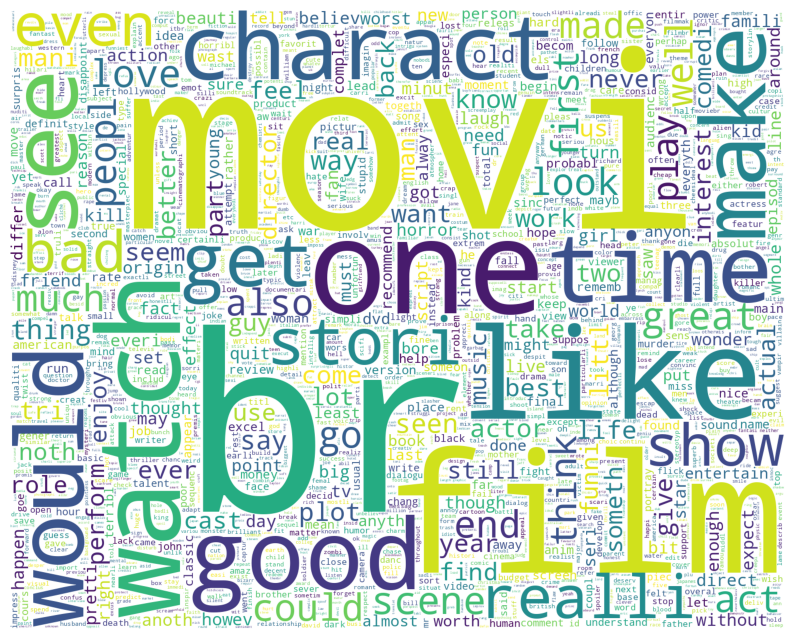

In [ ]:
X_tfidf_train, X_tfidf_test, tfidf_weights, vocab = tf_idf(X_train, X_test)

Wordcloud gives us picture of most wighted words in descending order

# GridSearchCV with 5 KFold and estimator SGDClassifier

In [ ]:
def grid_search_sgd(X_train, X_test, y_train, y_test):
    '''Grid-Search'''
    sgdc_model = SGDClassifier(shuffle=True, random_state=random_state)

    parameters = {
                  'alpha': [1e-5, 1e-4, 1e-3, 1e-2, 1e-1], # learning rate
                  'max_iter': [1500, 2000, 2500], # number of epochs
                  'loss': ['log_loss'], # default, logistic regression,
                  'penalty': ['l2'],
                  'n_jobs': [-1]
                  }
    # determine which combination of parameters leads to the best results
    grid_search = GridSearchCV(estimator=sgdc_model,param_grid=parameters,
                               cv=5, scoring='roc_auc')

    #['accuracy', 'f1', 'f1_weighted', 'roc_auc']

    grid = grid_search.fit(X_train, y_train)

    grid_y_pred = grid_search.predict(X_test)

    grid_y_proba = grid_search.predict_proba(X_test)

    print('Best roc_auc score: {}'.format(grid.best_score_))
    print('Best parameters: {}'.format(grid.best_params_))
    return grid, grid_search, grid_y_pred, grid_y_proba

In [ ]:
grid, grid_search, grid_y_pred, grid_y_proba = grid_search_sgd(X_tfidf_train, X_tfidf_test, y_train, y_test)

Best roc_auc score: 0.9439212776779484
Best parameters: {'alpha': 1e-05, 'loss': 'log_loss', 'max_iter': 1500, 'n_jobs': -1, 'penalty': 'l2'}


In [ ]:
def plot_metrics(estimator, X_train, X_test, y_train, y_test, y_pred):
  plt.rcParams['figure.figsize'] = 5, 5

  print(classification_report(y_test, y_pred))
  # # confusion matrix
  ConfusionMatrixDisplay.from_estimator(estimator, X_test, y_test)
  plt.title('Confusion Matrix')

  # ROC curve
  RocCurveDisplay.from_estimator(estimator, X_test, y_test)
  # title
  plt.title('ROC curve')
  # x label
  plt.xlabel('False Positive Rate')
  # y label
  plt.ylabel('True Positive rate')

  plt.show()

Classification report, ROC curve and AUC score

              precision    recall  f1-score   support

           0       0.87      0.89      0.88      7410
           1       0.89      0.86      0.87      7465

    accuracy                           0.88     14875
   macro avg       0.88      0.88      0.88     14875
weighted avg       0.88      0.88      0.88     14875



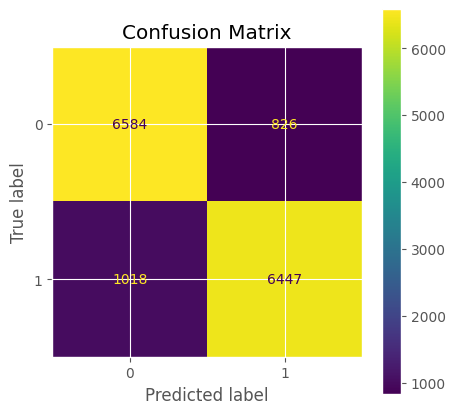

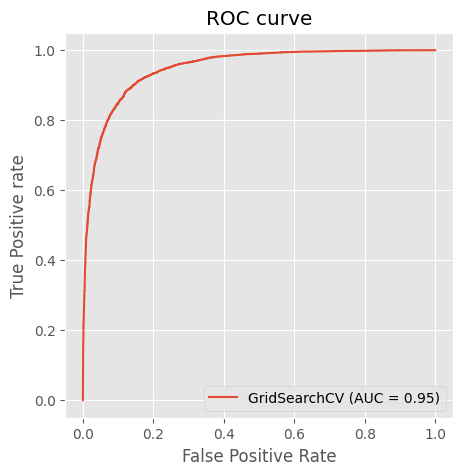

In [ ]:
plot_metrics(grid_search, X_tfidf_train, X_tfidf_test, y_train, y_test, grid_y_pred)

# Neural Network

In [ ]:
def tokenize_nn(X_train,X_test,vocab):
    word_list = vocab
    corpus = Counter(word_list)
    # sorting on the basis of most common words
    corpus_ = sorted(corpus,key=corpus.get,reverse=True)[:2000]
    # creating a dict
    onehot_dict = {w:i+1 for i,w in enumerate(corpus_)}

    # tockenize
    final_list_train,final_list_test = [],[]
    for sent in X_train:
            final_list_train.append([onehot_dict[word] for word in sent.lower().split()
                                     if word in onehot_dict.keys()])
    for sent in X_test:
            final_list_test.append([onehot_dict[word] for word in sent.lower().split()
                                    if word in onehot_dict.keys()])
    # print(word_list)
    return np.array(final_list_train), np.array(final_list_test), onehot_dict

In [ ]:
x_train,x_test,vocab = tokenize_nn(X_train,X_test, vocab)

In [ ]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


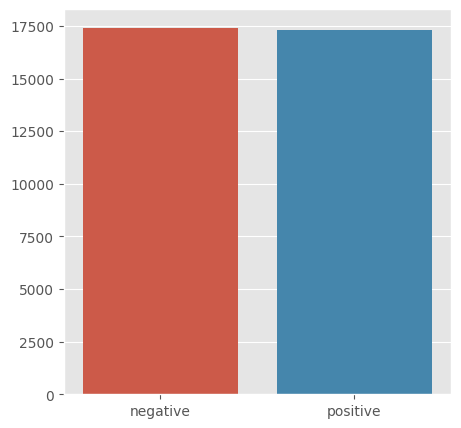

In [ ]:
dd = pd.Series(y_train).value_counts()
sns.barplot(x=np.array(['negative','positive']),y=dd.values)
plt.show()

In [ ]:
def padding_(sentences, seq_len):
    features = np.zeros((len(sentences), seq_len),dtype=int)
    for ii, review in enumerate(sentences):
        if len(review) != 0:
            features[ii, -len(review):] = np.array(review)[:seq_len]
    return features
#we have very less number of reviews with length > 1000.
#So we will consideronly those below it.
x_train_pad = padding_(x_train,1000)
x_test_pad = padding_(x_test,1000)

# load data

In [ ]:
def load_data(batch_size, bidir):
  # create Tensor datasets
  train_data = TensorDataset(torch.from_numpy(x_train_pad), torch.from_numpy(np.array(y_train)))
  valid_data = TensorDataset(torch.from_numpy(x_test_pad), torch.from_numpy(np.array(y_test)))

  # dataloaders


  # make sure to SHUFFLE your data
  train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size, drop_last=True)
  valid_loader = DataLoader(valid_data, shuffle=True, batch_size=batch_size, drop_last=True)
  return train_loader, valid_loader

### Model

In [ ]:
class SentimentRNN(nn.Module):
    def __init__(self,no_layers,vocab_size,hidden_dim,output_dim,bidir,embedding_dim,drop_prob=0.5):
        super(SentimentRNN,self).__init__()

        self.output_dim = output_dim
        self.hidden_dim = hidden_dim

        self.no_layers = no_layers
        self.vocab_size = vocab_size
        self.bidir=bidir

        # embedding and LSTM layers
        self.embedding = nn.Embedding(vocab_size, embedding_dim)

        #lstm
        self.lstm = nn.LSTM(input_size=embedding_dim,hidden_size=self.hidden_dim,
                           bidirectional=bidir,
                           num_layers=no_layers, batch_first=True)


        # dropout layer
        self.dropout = nn.Dropout(0.3)

        # linear and sigmoid layer
        self.fc = nn.Linear(self.hidden_dim, output_dim)
        self.sig = nn.Sigmoid()

    def forward(self,x,hidden):
        batch_size = x.size(0)
        # embeddings and lstm_out
        embeds = self.embedding(x)  # shape: B x S x Feature   since batch = True
        #print(embeds.shape)  #[50, 500, 1000]
        lstm_out, hidden = self.lstm(embeds, hidden)

        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)

        # dropout and fully connected layer
        out = self.dropout(lstm_out)
        out = self.fc(out)

        # sigmoid function
        sig_out = self.sig(out)

        # reshape to be batch_size first
        sig_out = sig_out.view(batch_size, -1)

        sig_out = sig_out[:, -1] # get last batch of labels

        # return last sigmoid output and hidden state
        return sig_out, hidden



    def init_hidden(self, batch_size, bidir):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x hidden_dim,
        # initialized to zero, for hidden state and cell state of LSTM
        if bidir:
          h0 = torch.zeros((2*self.no_layers,batch_size,self.hidden_dim)).to(device)
          c0 = torch.zeros((2*self.no_layers,batch_size,self.hidden_dim)).to(device)
        else:
          h0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
          c0 = torch.zeros((self.no_layers,batch_size,self.hidden_dim)).to(device)
        hidden = (h0,c0)
        return hidden



### Training

In [ ]:
def init_model(no_layers,vocab_size,hidden_dim,output_dim,bidir,embedding_dim,drop_prob=0.5):
  model = SentimentRNN(no_layers,vocab_size,hidden_dim,output_dim,bidir,embedding_dim,drop_prob=0.5)

  #moving to gpu
  model.to(device)

  lr=0.001

  criterion = nn.BCELoss()

  optimizer = torch.optim.Adam(model.parameters(), lr=lr)

  print(model)
  return model, criterion, optimizer


# function to predict accuracy
def acc(pred,label):
    pred = torch.round(pred.squeeze())
    return torch.sum(pred == label.squeeze()).item()


def train_model(batch_size, train_loader, valid_loader, bidir):

  clip = 5
  epochs = 5
  valid_loss_min = np.Inf
  # train for some number of epochs
  epoch_tr_loss,epoch_vl_loss = [],[]
  epoch_tr_acc,epoch_vl_acc = [],[]

  for epoch in range(epochs):
      train_losses = []
      train_acc = 0.0

      model.train()
      # initialize hidden state
      h = model.init_hidden(batch_size, bidir)
      # print(h)
      for inputs, labels in train_loader:

          inputs, labels = inputs.to(device), labels.to(device)
          # Creating new variables for the hidden state, otherwise
          # we'd backprop through the entire training history
          h = tuple([each.data for each in h])

          model.zero_grad()
  # print(model)
          output, h = model(inputs,h)

          # calculate the loss and perform backprop
          loss = criterion(output.squeeze(), labels.float())
          loss.backward()
          train_losses.append(loss.item())

          # calculating accuracy
          accuracy = acc(output,labels)
          train_acc += accuracy
          #`clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
          nn.utils.clip_grad_norm_(model.parameters(), clip)
          optimizer.step()



      # early stop vars
      count = 0
      min_val_loss = num.Inf
      correct = 0
      iter = 0
      count = 0
      total = 0
      n_epochs_stop = 6
      epochs_no_improve = 0
      early_stop = False

      val_h = model.init_hidden(batch_size, bidir)
      val_losses = []
      val_acc = 0.0

      model.eval()
      for inputs, labels in valid_loader:
        val_loss = 0
        val_h = tuple([each.data for each in val_h])

        inputs, labels = inputs.to(device), labels.to(device)

        output, val_h = model(inputs, val_h)
        val_loss = criterion(output.squeeze(), labels.float())

        val_losses.append(val_loss.item())

        accuracy = acc(output,labels)
        val_acc += accuracy

        # early stop logic
        val_loss += loss
        val_loss = val_loss / len(train_loader)
        # If the validation loss is at a minimum
        if val_loss < min_val_loss:
            epochs_no_improve = 0
            min_val_loss = val_loss

        else:
            epochs_no_improve += 1
        iter += 1
        if epoch > 3 and epochs_no_improve == n_epochs_stop:
            print('Early stopping!' )
            early_stop = True
            break
        else:
            continue
        break
        if iter % 336 == 0:
            # Calculate Accuracy
            correct = 0
            total = 0
    # Check early stopping condition
      if early_stop:
        print("Stopped")
        break
      epoch_train_loss = np.mean(train_losses)
      epoch_val_loss = np.mean(val_losses)
      epoch_train_acc = train_acc/len(train_loader.dataset)
      epoch_val_acc = val_acc/len(valid_loader.dataset)
      epoch_tr_loss.append(epoch_train_loss)
      epoch_vl_loss.append(epoch_val_loss)
      epoch_tr_acc.append(epoch_train_acc)
      epoch_vl_acc.append(epoch_val_acc)
      print(f'Epoch {epoch+1}')
      print(f'train_loss : {epoch_train_loss} val_loss : {epoch_val_loss}')
      print(f'train_accuracy : {epoch_train_acc*100} val_accuracy : {epoch_val_acc*100}')
      if epoch_val_loss <= valid_loss_min:
          torch.save(model.state_dict(), '/content/state_dict.pt')
          print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,epoch_val_loss))
          valid_loss_min = epoch_val_loss
      print(25*'==')
  return epoch_tr_loss, epoch_vl_loss, epoch_tr_acc, epoch_vl_acc

In [ ]:
def plot_results(epoch_tr_loss, epoch_vl_loss, epoch_tr_acc, epoch_vl_acc):
  fig = plt.figure(figsize = (20, 6))
  plt.subplot(1, 2, 1)
  plt.plot(epoch_tr_acc, label='Train Acc')
  plt.plot(epoch_vl_acc, label='Validation Acc')
  plt.title("Accuracy")
  plt.legend()
  plt.grid()

  plt.subplot(1, 2, 2)
  plt.plot(epoch_tr_loss, label='Train loss')
  plt.plot(epoch_vl_loss, label='Validation loss')
  plt.title("Loss")
  plt.legend()
  plt.grid()

  plt.show()

In [ ]:
def predict_text(text):
        word_seq = np.array([vocab[clean_sign_nums(word)] for word in text.split()
                         if clean_sign_nums(word) in vocab.keys()])
        word_seq = np.expand_dims(word_seq,axis=0)
        pad =  torch.from_numpy(padding_(word_seq,500))
        inputs = pad.to(device)
        batch_size = 1
        h = model.init_hidden(batch_size, bidir)
        h = tuple([each.data for each in h])
        output, h = model(inputs, h)
        return(output.item())

### Inferance

In [ ]:
def pos_negative():
  index = 30
  print(df['review'][index])
  print('='*70)
  print(f'Actual sentiment is  : {df["sentiment"][index]}')
  print('='*70)
  pro = predict_text(df['review'][index])
  status = "positive" if pro > 0.5 else "negative"
  pro = (1 - pro) if status == "negative" else pro
  print(f'Predicted sentiment is {status} with a probability of {pro}')

  index = 32
  print(df['review'][index])
  print('='*70)
  print(f'Actual sentiment is  : {df["sentiment"][index]}')
  print('='*70)
  pro = predict_text(df['review'][index])
  status = "positive" if pro > 0.5 else "negative"
  pro = (1 - pro) if status == "negative" else pro
  print(f'predicted sentiment is {status} with a probability of {pro}')

# Bidirectional LSTM model

In [ ]:
bidir = True
batch_size = 100
no_layers = 2
vocab_size = len(vocab) + 1 #extra 1 for padding
embedding_dim = 64
output_dim = 1
hidden_dim = 256

In [ ]:
train_loader, valid_loader = load_data(batch_size, bidir)

In [ ]:
model, criterion, optimizer = init_model(no_layers,vocab_size,hidden_dim,output_dim,bidir,
                                         embedding_dim,drop_prob=0.5)

SentimentRNN(
  (embedding): Embedding(2001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True, bidirectional=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [ ]:
epoch_tr_loss, epoch_vl_loss, epoch_tr_acc, epoch_vl_acc = train_model(batch_size, train_loader,
                                                                       valid_loader, bidir)

Epoch 1
train_loss : 0.5414697674749908 val_loss : 0.49817258884777893
train_accuracy : 72.01140980205723 val_accuracy : 75.96638655462185
Validation loss decreased (inf --> 0.498173).  Saving model ...
Epoch 2
train_loss : 0.4147300819412776 val_loss : 0.39685089553932884
train_accuracy : 82.11311839110266 val_accuracy : 83.8453781512605
Validation loss decreased (0.498173 --> 0.396851).  Saving model ...
Epoch 3
train_loss : 0.34798393791450205 val_loss : 0.34898828443240476
train_accuracy : 85.3430143775031 val_accuracy : 84.61848739495798
Validation loss decreased (0.396851 --> 0.348988).  Saving model ...
Epoch 4
train_loss : 0.3144237005315528 val_loss : 0.3195097405161407
train_accuracy : 87.17549773820843 val_accuracy : 86.1781512605042
Validation loss decreased (0.348988 --> 0.319510).  Saving model ...
Early stopping!
Stopped


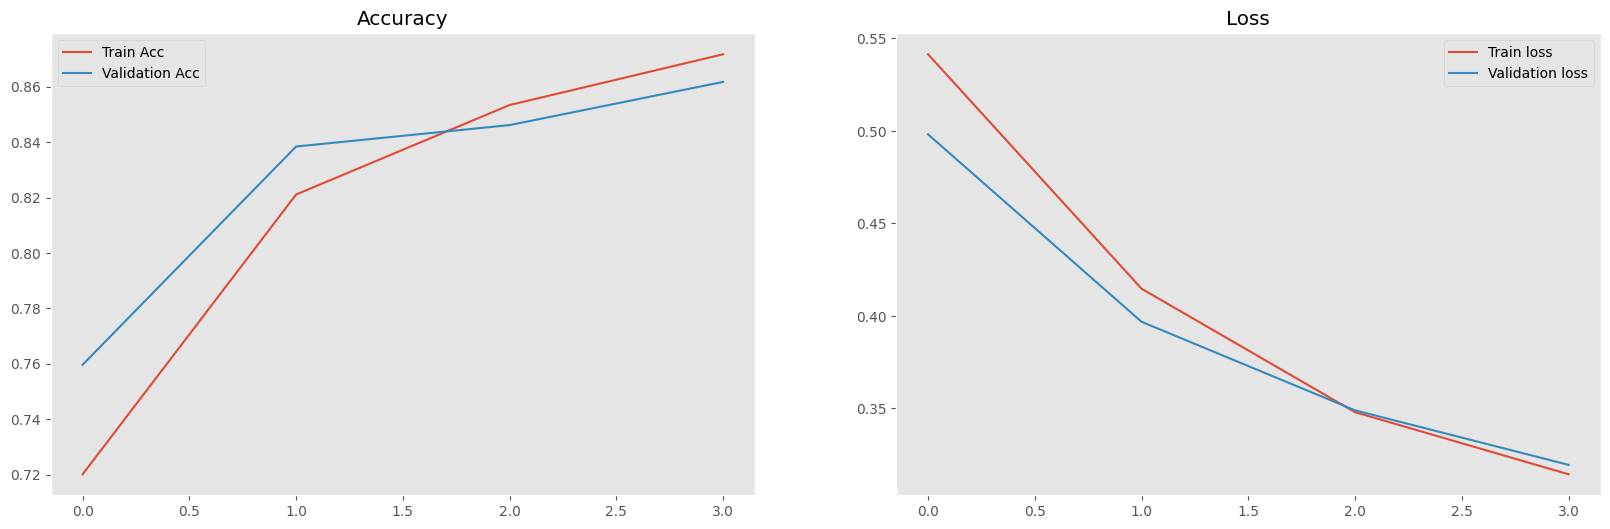

In [ ]:
plot_results(epoch_tr_loss, epoch_vl_loss, epoch_tr_acc, epoch_vl_acc)

In [ ]:
pos_negative()

taut organ grip edward dmytryk crossfir distinct suspens thriller unlik `` messag '' movi use look devic noir cyclebr br bivouack washington dc compani soldier cope restless hang bar three end stranger apart robert ryan drunk belliger beat host sam leven death happen jewish polic detect robert young investig help robert mitchum assign ryan outfit suspicion fall second three georg cooper vanish ryan slay third buddi steve brodi insur silenc young close inbr br abet superior script john paxton dmytryk draw precis perform three star bob ryan natur prototyp angri white male hilt mitchum underplay characterist alert nonchal role howev central young may never better gloria graham give first fullyfledg rendit smartmouth vulner tramp sad sack leech life paul kelli haunt us small peripher role make memorablebr br polit engag dmytryk perhap inevit succumb sermon pretti much confin young reminisc irish grandfath die hand bigot centuri earlier thu incident stretch chronolog limit least attempt ren

# Unidirectional LSTM model

In [ ]:
bidir = False

In [ ]:
train_loader, valid_loader = load_data(batch_size, bidir)

In [ ]:
model, criterion, optimizer = init_model(no_layers,vocab_size,hidden_dim,output_dim,bidir,
                                         embedding_dim,drop_prob=0.5)

SentimentRNN(
  (embedding): Embedding(2001, 64)
  (lstm): LSTM(64, 256, num_layers=2, batch_first=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (fc): Linear(in_features=256, out_features=1, bias=True)
  (sig): Sigmoid()
)


In [ ]:
epoch_tr_loss, epoch_vl_loss, epoch_tr_acc, epoch_vl_acc = train_model(batch_size, train_loader,
                                                                       valid_loader, bidir)

Epoch 1
train_loss : 0.5437637368265421 val_loss : 0.40200459171791336
train_accuracy : 71.65989569827413 val_accuracy : 82.19159663865547
Validation loss decreased (inf --> 0.402005).  Saving model ...
Epoch 2
train_loss : 0.38925942194564883 val_loss : 0.3549430074321257
train_accuracy : 83.13020428155703 val_accuracy : 84.49747899159664
Validation loss decreased (0.402005 --> 0.354943).  Saving model ...
Epoch 3
train_loss : 0.34132903797138664 val_loss : 0.3492172522520697
train_accuracy : 85.67435963926584 val_accuracy : 85.43193277310924
Validation loss decreased (0.354943 --> 0.349217).  Saving model ...
Epoch 4
train_loss : 0.2986427323103638 val_loss : 0.3310835343357679
train_accuracy : 87.8180194197136 val_accuracy : 85.48571428571428
Validation loss decreased (0.349217 --> 0.331084).  Saving model ...
Early stopping!
Stopped


In [ ]:
pos_negative()

taut organ grip edward dmytryk crossfir distinct suspens thriller unlik `` messag '' movi use look devic noir cyclebr br bivouack washington dc compani soldier cope restless hang bar three end stranger apart robert ryan drunk belliger beat host sam leven death happen jewish polic detect robert young investig help robert mitchum assign ryan outfit suspicion fall second three georg cooper vanish ryan slay third buddi steve brodi insur silenc young close inbr br abet superior script john paxton dmytryk draw precis perform three star bob ryan natur prototyp angri white male hilt mitchum underplay characterist alert nonchal role howev central young may never better gloria graham give first fullyfledg rendit smartmouth vulner tramp sad sack leech life paul kelli haunt us small peripher role make memorablebr br polit engag dmytryk perhap inevit succumb sermon pretti much confin young reminisc irish grandfath die hand bigot centuri earlier thu incident stretch chronolog limit least attempt ren

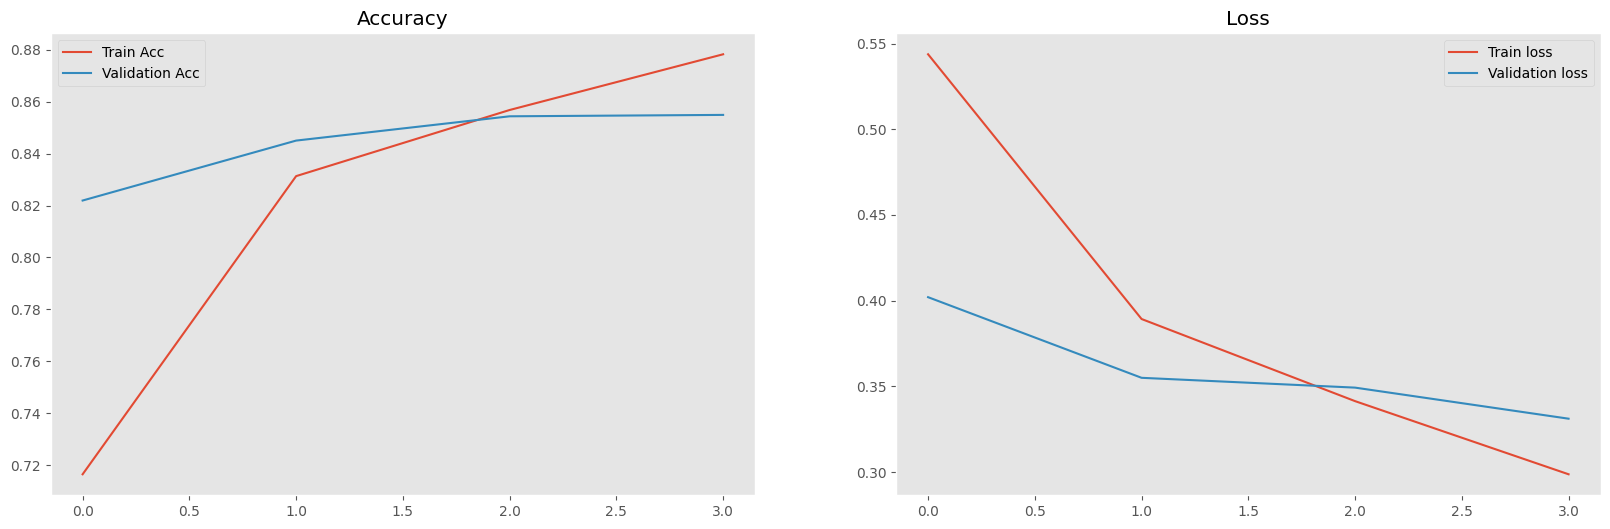

In [ ]:
plot_results(epoch_tr_loss, epoch_vl_loss, epoch_tr_acc, epoch_vl_acc)

# pretrained models: word2vec

In [ ]:
# remove punctiation
df["review"] = df["review"].apply(lambda s: s.translate(str.maketrans('', '', string.punctuation)))

In [ ]:
df.head()

,review,sentiment
0,one review mention watch oz episod hook right ...,1
1,wonder littl product br br film techniqu unass...,1
2,thought wonder way spend time hot summer weeke...,1
3,basic famili littl boy jake think zombi closet...,0
4,petter mattei love time money visual stun fi...,1


In [ ]:
texts = list(df.review.unique())
print(texts[0:2])

tokenized_texts = [word_tokenize(text) for text in texts]
print([' '.join(row) for row in tokenized_texts[:1]])

['one review mention watch oz episod hook right exactli happen mebr br first thing struck oz brutal unflinch scene violenc set right word go trust show faint heart timid show pull punch regard drug sex violenc hardcor classic use wordbr br call oz nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda citi home manyaryan muslim gangsta latino christian italian irish moreso scuffl death stare dodgi deal shadi agreement never far awaybr br would say main appeal show due fact goe show would dare forget pretti pictur paint mainstream audienc forget charm forget romanceoz mess around first episod ever saw struck nasti surreal could say readi watch develop tast oz got accustom high level graphic violenc violenc injustic crook guard sold nickel inmat kill order get away well manner middl class inmat turn prison bitch due lack street skill prison experi watch oz may becom comfort uncomfort viewin

Train model:

In [ ]:
model = Word2Vec(tokenized_texts,
                 vector_size=32,      # embedding vector size
                 min_count=5,  # consider words that occured at least 5 times
                 window=5).wv  # define context as a 5-word window around the target word

## Examine the model

In [ ]:
model.get_vector('classic')

array([ 0.9170752 , -1.999972  , -0.3978299 ,  0.1871671 , -2.4845946 ,
       -3.263822  ,  0.9547521 , -0.2863335 , -2.0737872 , -1.7274693 ,
       -2.4769144 , -1.0343475 ,  0.11504208, -1.6425544 , -2.5003633 ,
        1.0201716 ,  2.7453852 ,  0.05522984,  1.1803277 ,  1.7904065 ,
       -0.95130056, -0.6330493 ,  2.9503603 ,  0.19585022, -2.1612086 ,
        2.3459127 ,  1.719576  ,  0.82510924,  2.928615  ,  1.3332636 ,
        1.1715921 , -0.30678156], dtype=float32)

Most similar words:

In [ ]:
model.most_similar('classic')

[('antholog', 0.7155981063842773),
 ('aficionado', 0.6918333172798157),
 ('masterpiec', 0.6822188496589661),
 ('dunwich', 0.6766273975372314),
 ('sf', 0.674897313117981),
 ('sciencefict', 0.6742176413536072),
 ('icon', 0.6724329590797424),
 ('cult', 0.6722012758255005),
 ('spoof', 0.670601487159729),
 ('liveact', 0.6628301739692688)]

## Model visualisation

In [ ]:
# Let's take a look on 1k most frequent words
words = model.index_to_key[:1000]
print(words[::100])

# Constructing embedding matrix
word_vectors = model.vectors[[model.key_to_index[word] for word in words]]

['br', 'got', 'someon', 'either', 'type', 'particularli', 'modern', 'box', 'uniqu', 'italian']


### PCA Visualisation

In [ ]:
def get_pca_projection(word_vectors):
    pca = PCA(n_components=2)
    return pca.fit_transform(word_vectors)

In [ ]:
word_vectors_pca = get_pca_projection(word_vectors)

In [ ]:
# Visualization function

def draw_vectors(x, y, radius=10, alpha=0.25, color='blue',
                 width=600, height=400, show=True, **kwargs):
    """ draws an interactive plot for data points with auxilirary info on hover """
    output_notebook()

    if isinstance(color, str):
        color = [color] * len(x)
    data_source = bm.ColumnDataSource({ 'x' : x, 'y' : y, 'color': color, **kwargs })

    fig = pl.figure(active_scroll='wheel_zoom', width=width, height=height)
    fig.scatter('x', 'y', size=radius, color='color', alpha=alpha, source=data_source)

    fig.add_tools(bm.HoverTool(tooltips=[(key, "@" + key) for key in kwargs.keys()]))
    if show:
        pl.show(fig)
    return fig

In [ ]:
draw_vectors(word_vectors_pca[:, 0], word_vectors_pca[:, 1], token=words)

Figure(id='1003', ...)

### TSNE

In [ ]:
def get_tsne_projection(word_vectors):
    tsne = TSNE(n_components=2)
    return tsne.fit_transform(word_vectors)

In [ ]:
word_tsne = get_tsne_projection(word_vectors)
draw_vectors(word_tsne[:, 0], word_tsne[:, 1], color='green', token=words)

Figure(id='1113', ...)

## Sentence embeddings

In [ ]:
# pretrained model for ease of operations
model = api.load('glove-twitter-100')
print(api.info('glove-twitter-100'))

[=================================================-] 99.9% 386.7/387.1MB downloaded
{'num_records': 1193514, 'file_size': 405932991, 'base_dataset': 'Twitter (2B tweets, 27B tokens, 1.2M vocab, uncased)', 'reader_code': 'https://github.com/RaRe-Technologies/gensim-data/releases/download/glove-twitter-100/__init__.py', 'license': 'http://opendatacommons.org/licenses/pddl/', 'parameters': {'dimension': 100}, 'description': 'Pre-trained vectors based on  2B tweets, 27B tokens, 1.2M vocab, uncased (https://nlp.stanford.edu/projects/glove/)', 'preprocessing': 'Converted to w2v format with `python -m gensim.scripts.glove2word2vec -i <fname> -o glove-twitter-100.txt`.', 'read_more': ['https://nlp.stanford.edu/projects/glove/', 'https://nlp.stanford.edu/pubs/glove.pdf'], 'checksum': 'b04f7bed38756d64cf55b58ce7e97b15', 'file_name': 'glove-twitter-100.gz', 'parts': 1}


The easy way to obtain sentence embedding is to get mean embedding of words in sentence.

In [ ]:
def get_phrase_embedding(model, phrase):
    tokenized = word_tokenize(phrase.lower())
    if len(tokenized) > 0:
        vector = model.get_mean_vector(tokenized)
        return vector
    return np.zeros([model.vector_size], dtype='float32')

In [ ]:
vector = get_phrase_embedding(model, "I'm very sure. This never happened to me before...")

vector.shape

(100,)

Creating vectors for every sentence



In [ ]:
text_vectors = np.array([get_phrase_embedding(model, phrase) for phrase in texts])

In [ ]:
# Let's find out most closest questions to each other

def find_nearest(model, text_vectors, texts, query, k=10):
    query = get_phrase_embedding(model, query)
    sim_scores = cosine_similarity(text_vectors, query.reshape(1, -1)).reshape(1,-1)
    k_idx = np.argpartition(-sim_scores, k)[: , :k]
    return np.array(texts)[k_idx]

In [ ]:
texts[4]

'petter mattei  love time money  visual stun film watch mr mattei offer us vivid portrait human relat movi seem tell us money power success peopl differ situat encount br br variat arthur schnitzler play theme director transfer action present time new york differ charact meet connect one connect one way anoth next person one seem know previou point contact stylishli film sophist luxuri look taken see peopl live world live habitatbr br thing one get soul pictur differ stage loneli one inhabit big citi exactli best place human relat find sincer fulfil one discern case peopl encounterbr br act good mr mattei direct steve buscemi rosario dawson carol kane michael imperioli adrian grenier rest talent cast make charact come alivebr br wish mr mattei good luck await anxious next work'

In [ ]:
find_nearest(model, text_vectors, texts,
             query="arthur schnitzler play theme director transfer action present time new york ",
             k=3)

array([['marin tell di accur portray date depict marin corp boot camp boy turn men jack webb excel sgtjim moor tough fair drill instructor pari island north carolina film center one recruit seem  get program  recent film full metal jacket also show life basic train well worth view',
        'low budget project film success stori interest actor convinc eva longoria star tv show  dragnet  sexier ever locat ideal ganster plot director show talent take mani role project cours low budget film could use better edit transit special effect gun scene music keep script move although film share problem continu must say would rent director next movi film student could learn thing director commentari',
        'one best reunion special ever adam west burt ward parodi fun amaz amount effort went detail particularli recaptur feel era batcav set wayn manor costum actor select play younger version west ward burgess meredith cesar romero frank gorshin minut well worth time delight fan classic  batman  t

In [ ]:
results = find_nearest(model, text_vectors, texts, query="How do i enter the matrix?", k=3)
print(results)

[['realli love movi saw first time work video store went buy told print could order today thought would look found put spain dvd name  algo ma que amigo  buy english spanish dvdhope help know hard find movi love releas us market best luckoh info one place look httpwwwzonadvdcom think go dollar usd ebay well'
  'final thought someon go justic hg wellss classic anoth version set wrong local era one base firmli book well definit follow book pretti close plu messbr br min ye hour long book around page br br timothi hine nerv come say  better  would say  ye could  never use video camera sort drama school lifebr br paid good money get crap uk usa make mistak'
  'mario invit princess peach castl cake mario get find bowser kidnap mario must save day unlik game mario explor anyth want roam around climb tree tri look up find secret level spend four hour one level time limit world number stage star door need certain number star get get star door must go stage fight bowser end stage get certain wo

# PyTorch basics

## Automatic differentation

### Computational graphs

Computational graphs - is easu way to calculate complex functions gradients

For example with function

$$f = (x + y) \cdot z$$

would look like a graph

![graph](https://image.ibb.co/mWM0Lx/1_6o_Utr7_ENFHOK7_J4l_XJtw1g.png)  
*From [Backpropagation, Intuitions - CS231n](http://cs231n.github.io/optimization-2/)*


Let's see that example
First define function in Pytorch:

In [ ]:
with torch.autograd.no_grad():
    x = torch.tensor(-2., requires_grad=True)
    y = torch.tensor(5., requires_grad=True)
    q = x + y

z = torch.tensor(-4., requires_grad=True)
f = q * z

f.backward()

print('df/dz =', z.grad)
print('df/dx =', x.grad)
print('df/dy =', y.grad)

df/dz = tensor(3.)
df/dx = None
df/dy = None


In [ ]:
x.data

tensor(-2.)

Collected gradient:

In [ ]:
x.grad

Function to calculate that gradient:

In [ ]:
q.grad_fn

And more

In [ ]:
x.type(), x.shape, x.device, x.layout

('torch.FloatTensor', torch.Size([]), device(type='cpu'), torch.strided)

## Word embeddings and PyTorch API

Collect word frequency counts:

In [ ]:
MIN_COUNT = 5

words_counter = Counter(token for tokens in tokenized_texts for token in tokens)
word2index = {
    '<unk>': 0
}

for word, count in words_counter.most_common():
    if count < MIN_COUNT:
        break

    word2index[word] = len(word2index)

index2word = [word for word, _ in sorted(word2index.items(), key=lambda x: x[1])]

print('Vocabulary size:', len(word2index))
print('Tokens count:', sum(len(tokens) for tokens in tokenized_texts))
print('Unknown tokens appeared:', sum(1 for tokens in tokenized_texts for token in tokens if token not in word2index))
print('Most freq words:', index2word[1:21])

Vocabulary size: 30913
Tokens count: 5926045
Unknown tokens appeared: 146177
Most freq words: ['br', 'movi', 'film', 'one', 'like', 'time', 'good', 'make', 'would', 'get', 'see', 'charact', 'watch', 'even', 'stori', 'realli', 'scene', 'show', 'well', 'look']


### Skip-Gram Word2vec

Simple model consists of 2 layers. Main idea to train embedding vectors in the way to predict context of words.

For that reason probabilities are modelled in the following way $\{P(w_{c+j}|w_c):  j = c-k, ..., c+k, j \neq c\}$, where $k$ - context windoe size, $c$ - central word index.

Model architecture will be: pair of matrices $U$ - embedding matrix, which we will use for tasks, and $V$ -output layer matrix.

For every word in dictionary we have referring row in $U$ and column in $V$.

![skip-gram](https://image.ibb.co/khFXu9/Skip_gram.png)

Word is transformed into embedding - row $u_c$. Next that embeddding multiplied on $V$.

And we got scores $v_j^T u_c$ - similarity of word $j$ and initially passed word.

To make it more like probabilities we will use softmax function: $P(i) = \frac{e^{x_i}}{\sum_j e^{x_j}}$.

And cross entropy loss to make optimization:

$$-\sum_{-k \leq j \leq k, j \neq 0} \log \frac{\exp(v_{c+j}^T u_c)}{\sum_{i=1}^{|V|} \exp(v_i^T u_c)} \to \min_{U, V}.$$

At the end, vector $u_c$ will start to be closer to vectors $v_{c_j}$ from its context.

Let's create it.

#### Batch generation

First we need to collect contexts.

In [ ]:
def build_contexts(tokenized_texts, window_size):
    contexts = []
    for tokens in tokenized_texts:
        for i in range(len(tokens)):
            central_word = tokens[i]
            context = [tokens[i + delta] for delta in range(-window_size, window_size + 1)
                       if delta != 0 and i + delta >= 0 and i + delta < len(tokens)]

            contexts.append((central_word, context))

    return contexts

In [ ]:
contexts = build_contexts(tokenized_texts, window_size=2)

In [ ]:
contexts[:5]

[('one', ['review', 'mention']),
 ('review', ['one', 'mention', 'watch']),
 ('mention', ['one', 'review', 'watch', 'oz']),
 ('watch', ['review', 'mention', 'oz', 'episod']),
 ('oz', ['mention', 'watch', 'episod', 'hook'])]

Cast words to their indicies in vocab

In [ ]:
contexts = [(word2index.get(central_word, 0), [word2index.get(word, 0) for word in context])
            for central_word, context in contexts]

Implement batch generator for our network:

In [ ]:
def make_skip_gram_batchs_iter(contexts, window_size, num_skips, batch_size):
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * window_size

    central_words = [word for word, context in contexts if len(context) == 2 * window_size and word != 0]
    contexts = [context for word, context in contexts if len(context) == 2 * window_size and word != 0]

    batch_size = int(batch_size / num_skips)
    batchs_count = int(math.ceil(len(contexts) / batch_size))

    print('Initializing batchs generator with {} batchs per epoch'.format(batchs_count))

    while True:
        indices = np.arange(len(contexts))
        np.random.shuffle(indices)

        for i in range(batchs_count):
            batch_begin, batch_end = i * batch_size, min((i + 1) * batch_size, len(contexts))
            batch_indices = indices[batch_begin: batch_end]

            batch_data, batch_labels = [], []

            for data_ind in batch_indices:
                central_word, context = central_words[data_ind], contexts[data_ind]

                words_to_use = random.sample(context, num_skips)
                batch_data.extend(words_to_use)
                batch_labels.extend([central_word] * num_skips)

            yield batch_data, batch_labels

In [ ]:
batch, labels = next(make_skip_gram_batchs_iter(contexts, window_size=2, num_skips=2, batch_size=32))

Initializing batchs generator with 349114 batchs per epoch


#### nn.Sequential

Simpliest way to create network is to use nn.Sequential from PyTorch model

In [ ]:
model = nn.Sequential(
    nn.Embedding(len(word2index), 32),
    nn.Linear(32, len(word2index))
)

In [ ]:
is_cuda = torch.cuda.is_available()

# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")
model = model.to(device)

GPU is available


#### Train loop

In [ ]:
loss_every_nsteps = 1000
total_loss = 0
start_time = time.time()

model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_function = nn.CrossEntropyLoss().to(device)


for step, (batch, labels) in enumerate(make_skip_gram_batchs_iter(contexts, window_size=2, num_skips=4, batch_size=128)):
    batch = torch.LongTensor(batch).to(device)
    labels = torch.LongTensor(labels).to(device)

    logits = model(batch)
    loss = loss_function(logits, labels)

    loss.backward()

    optimizer.step()

    optimizer.zero_grad()

    total_loss += loss.item()

    if step != 0 and step % loss_every_nsteps == 0:
        print("Step = {}, Avg Loss = {:.4f}, Time = {:.2f}s".format(step, total_loss / loss_every_nsteps,
                                                                    time.time() - start_time))
        total_loss = 0
        start_time = time.time()
    # for time reasons
    if step > 30000:
        break

Initializing batchs generator with 174557 batchs per epoch
Step = 1000, Avg Loss = 8.8706, Time = 6.01s
Step = 2000, Avg Loss = 8.4248, Time = 2.25s
Step = 3000, Avg Loss = 8.3490, Time = 2.25s
Step = 4000, Avg Loss = 8.3245, Time = 2.23s
Step = 5000, Avg Loss = 8.2644, Time = 2.41s
Step = 6000, Avg Loss = 8.2340, Time = 2.43s
Step = 7000, Avg Loss = 8.2325, Time = 2.23s
Step = 8000, Avg Loss = 8.2074, Time = 2.25s
Step = 9000, Avg Loss = 8.2180, Time = 2.22s
Step = 10000, Avg Loss = 8.2616, Time = 2.22s
Step = 11000, Avg Loss = 8.2214, Time = 2.55s
Step = 12000, Avg Loss = 8.2039, Time = 3.31s
Step = 13000, Avg Loss = 8.2494, Time = 2.40s
Step = 14000, Avg Loss = 8.2207, Time = 2.25s
Step = 15000, Avg Loss = 8.2166, Time = 2.22s
Step = 16000, Avg Loss = 8.2401, Time = 2.27s
Step = 17000, Avg Loss = 8.2168, Time = 2.46s
Step = 18000, Avg Loss = 8.1844, Time = 2.33s
Step = 19000, Avg Loss = 8.1779, Time = 2.24s
Step = 20000, Avg Loss = 8.2287, Time = 2.22s
Step = 21000, Avg Loss = 8.198

#### Result analysis

Let's get embeddings from GPU to numpy

In [ ]:
embeddings = model[0].weight.cpu().data.numpy()

And check how it looks like

In [ ]:
def most_similar(embeddings, index2word, word2index, word):
    word_emb = embeddings[word2index[word]]

    similarities = cosine_similarity([word_emb], embeddings)[0]
    top10 = np.argsort(similarities)[-10:]

    return [index2word[index] for index in reversed(top10)]

most_similar(embeddings, index2word, word2index, 'classic')

['classic',
 'flatter',
 'reeler',
 'tomoko',
 'stevenson',
 'sketch',
 'homegrown',
 'late',
 'hitchcock',
 'xu']

### CBOW
Alternative model variant:

![](https://image.ibb.co/jnsW49/CBOW.png)

Now using *sum* context vector central word vector is predicted.

In [ ]:
def make_cbow_batchs_iter(contexts, window_size, batch_size):
    data = np.array([context for word, context in contexts if len(context) == 2 * window_size and word != 0])
    labels = np.array([word for word, context in contexts if len(context) == 2 * window_size and word != 0])

    batchs_count = int(math.ceil(len(data) / batch_size))

    print('Initializing batchs generator with {} batchs per epoch'.format(batchs_count))

    while True:
        indices = np.arange(len(data))
        np.random.shuffle(indices)

        for i in range(batchs_count):
            batch_begin, batch_end = i * batch_size, min((i + 1) * batch_size, len(contexts))
            batch_indices = indices[batch_begin: batch_end]

            batch_data, batch_labels = [], []

            for data_ind in batch_indices:
                data_sample, label = data[data_ind], labels[data_ind]
                batch_data.extend(data_sample)
                batch_labels.extend([label] * len(data_sample))

            yield batch_data, batch_labels

In [ ]:
class CBoWModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super().__init__()

        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.out_layer = nn.Linear(embedding_dim, vocab_size)

    def forward(self, inputs):
        hidden = self.embeddings(inputs)
        output = self.out_layer(hidden)
        return output

model = CBoWModel(vocab_size=len(word2index), embedding_dim=32).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01)
loss_function = nn.CrossEntropyLoss().to(device)

In [ ]:
loss_every_nsteps = 1000
total_loss = 0
start_time = time.time()

for step, (batch, labels) in enumerate(make_cbow_batchs_iter(contexts, window_size=2, batch_size=128)):
    batch = torch.LongTensor(batch).to(device)
    labels = torch.LongTensor(labels).to(device)

    logits = model(batch)
    loss = loss_function(logits, labels)

    loss.backward()

    optimizer.step()

    optimizer.zero_grad()

    total_loss += loss.item()

    if step != 0 and step % loss_every_nsteps == 0:
        print("Step = {}, Avg Loss = {:.4f}, Time = {:.2f}s".format(step, total_loss / loss_every_nsteps,
                                                                    time.time() - start_time))
        total_loss = 0
        start_time = time.time()
    # for time reasons
    if step > 30000:
        break

Initializing batchs generator with 43640 batchs per epoch
Step = 1000, Avg Loss = 8.5155, Time = 10.39s
Step = 2000, Avg Loss = 8.1951, Time = 5.61s
Step = 3000, Avg Loss = 8.1131, Time = 5.52s
Step = 4000, Avg Loss = 8.0525, Time = 5.74s
Step = 5000, Avg Loss = 8.0120, Time = 5.52s
Step = 6000, Avg Loss = 7.9929, Time = 5.75s
Step = 7000, Avg Loss = 7.9720, Time = 5.51s
Step = 8000, Avg Loss = 7.9537, Time = 5.60s
Step = 9000, Avg Loss = 7.9429, Time = 5.66s
Step = 10000, Avg Loss = 7.9361, Time = 5.51s
Step = 11000, Avg Loss = 7.9328, Time = 5.74s
Step = 12000, Avg Loss = 7.9177, Time = 5.51s
Step = 13000, Avg Loss = 7.9112, Time = 5.67s
Step = 14000, Avg Loss = 7.9151, Time = 5.58s
Step = 15000, Avg Loss = 7.9096, Time = 6.82s
Step = 16000, Avg Loss = 7.9064, Time = 5.63s
Step = 17000, Avg Loss = 7.9064, Time = 5.52s
Step = 18000, Avg Loss = 7.9023, Time = 5.75s
Step = 19000, Avg Loss = 7.9046, Time = 5.52s
Step = 20000, Avg Loss = 7.8972, Time = 5.70s
Step = 21000, Avg Loss = 7.897

In [ ]:
embeddings = model.embeddings.weight.cpu().data.numpy()

In [ ]:
most_similar(embeddings, index2word, word2index, 'classic')

['classic',
 'horror',
 'genr',
 'graaff',
 'simon',
 'unfortunatli',
 'adventur',
 'origin',
 'runofthemil',
 'brownrigg']